In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo

chess_king_rook_vs_king = fetch_ucirepo(id=23) 
  
X = chess_king_rook_vs_king.data.features 
y = chess_king_rook_vs_king.data.targets 

df = pd.concat([X, y], axis=1)
df.columns = df.columns.str.replace("-", "_")

depth_map = {
    "draw": -1,
    "zero": 0,
    "one": 1,
    "two": 2,
    "three": 3,
    "four": 4,
    "five": 5,
    "six": 6,
    "seven": 7,
    "eight": 8,
    "nine": 9,
    "ten": 10,
    "eleven": 11,
    "twelve": 12,
    "thirteen": 13,
    "fourteen": 14,
    "fifteen": 15,
    "sixteen": 16
}

df["white_depth_of_win"] = df["white_depth_of_win"].astype(str).str.lower()
unknown = set(df["white_depth_of_win"].unique()) - set(depth_map.keys())

df["white_depth_of_win"] = df["white_depth_of_win"].map(depth_map).astype(int)

In [22]:
file_map = {a: i for i, a in enumerate("abcdefgh", start=1)}

for col in ["white_king_file", "white_rook_file", "black_king_file"]:
    df[col + "_n"] = df[col].astype(str).str.lower().map(file_map)


In [23]:


dx = (df["white_king_file_n"] - df["black_king_file_n"]).abs()
dy = (df["white_king_rank"].astype(int) - df["black_king_rank"].astype(int)).abs()

df["dist_euclid_wk_bk"] = np.sqrt(dx**2 + dy**2)
df["dist_manhattan_wk_bk"] = dx + dy
df["dist_chebyshev"] = np.maximum(dx,dy)

df["black_dist_edge_2"] = pd.concat([
    df["black_king_file_n"] - 1,
    8 - df["black_king_file_n"],
    df["black_king_rank"].astype(int) - 1,
    8 - df["black_king_rank"].astype(int)
], axis=1).min(axis=1).astype(int)


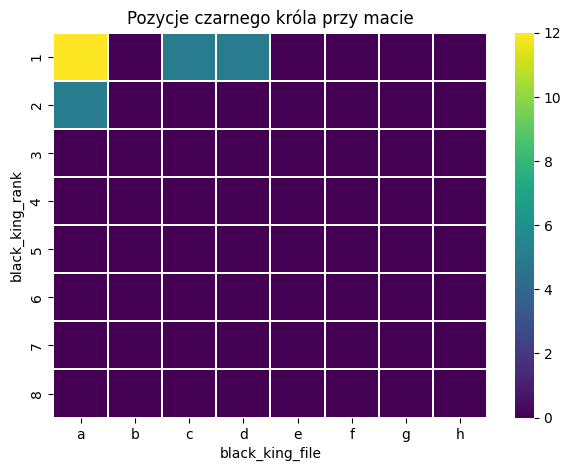

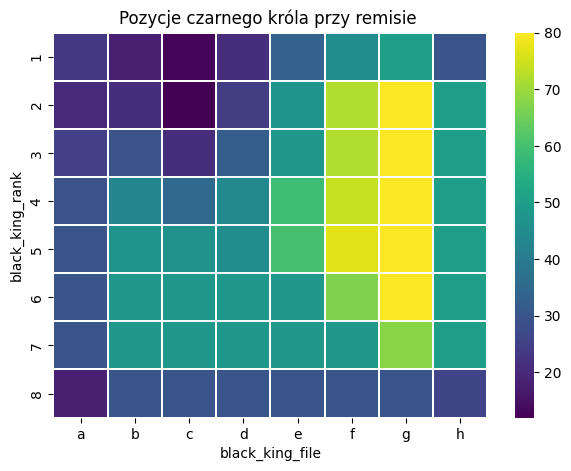

In [24]:

def heatmap_black_king(df_subset, title):
    board = (df_subset.groupby(["black_king_rank", "black_king_file"]).size().unstack(fill_value=0).reindex(index=range(1, 9), fill_value=0).reindex(columns=list("abcdefgh"), fill_value=0)          )

    plt.figure(figsize=(7, 5))
    ax = sns.heatmap(board, cmap="viridis", linewidths=0.2, linecolor="white")
    ax.set_title(title)
    ax.set_xlabel("black_king_file")
    ax.set_ylabel("black_king_rank")
    plt.show()

df_mate = df[df["white_depth_of_win"] == 0]
heatmap_black_king(df_mate, "Pozycje czarnego króla przy macie")

df_draw = df[df["white_depth_of_win"] == -1]
heatmap_black_king(df_draw, "Pozycje czarnego króla przy remisie ")


kiedy matowany, czarny król znajduje się praktycznie wyłącznie w rogu planszy i jego okolicach co widzimy na wykresie. Jest to w pełni logiczne jeśli weźmiemy pod uwagę charakterystykę tego endgame'u w szachach. 
Dla remisów za to najczęstsze pozycje znajdują się relatywnie bliżej środka planszy- tam gdzie wolnośc ruchu jest wyższa.
W obu przypadkach musimy pamiętać, że zbiór danych zawiera pozycje nieuwzględniające (zredukowane) pozycji symetrycznych względem szachownicy.
widzimy więc, że wynik silnie zależy od pozycji króla- pozycje bliskie rogów i krawędzi planszy znacznie częściej będą prowadzić do mata.

In [ ]:
df_win = df[df["white_depth_of_win"] >= 0].copy()

metrics = [
    ("dist_euclid_wk_bk", "Dystans euklidesowy"),
    ("dist_manhattan_wk_bk", "Dystans Manhattan"),
    ("dist_chebyshev", "Dystans Czebyszewa"),
]

rows = []
for col, label in metrics:
    pearson = df_win[[col, "white_depth_of_win"]].corr(method="pearson").iloc[0, 1]
    spearman = df_win[[col, "white_depth_of_win"]].corr(method="spearman").iloc[0, 1]
    rows.append({"metryka": label, "kolumna": col, "pearson": pearson, "spearman": spearman})

corr_df = pd.DataFrame(rows).sort_values("spearman", ascending=False)
corr_df

,metryka,kolumna,pearson,spearman
1,Dystans Manhattan,dist_manhattan_wk_bk,0.296696,0.256605
0,Dystans euklidesowy,dist_euclid_wk_bk,0.290681,0.242819
2,Dystans Czebyszewa,dist_chebyshev,0.266009,0.212660


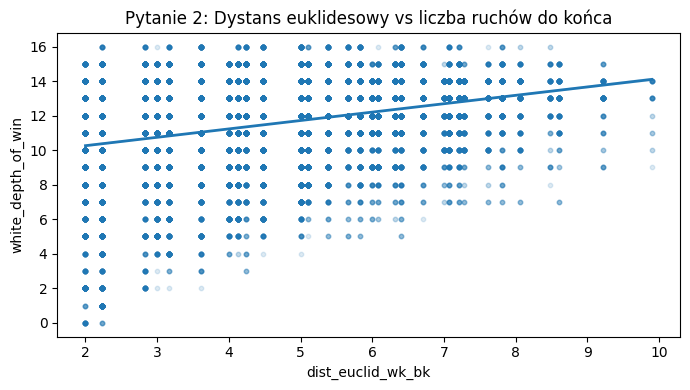

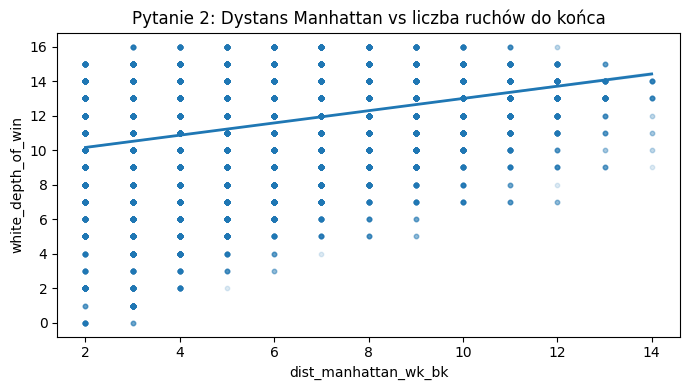

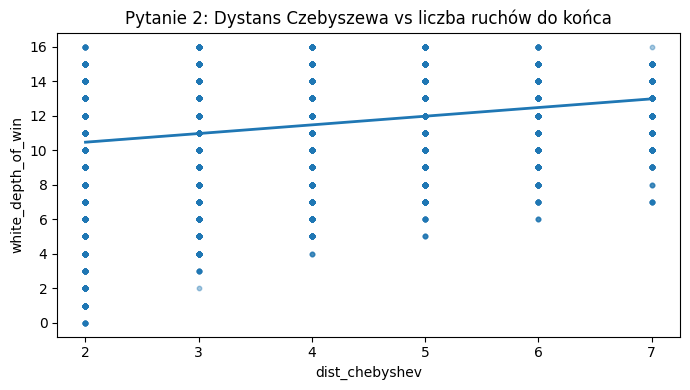

In [27]:

for col, label in metrics:
    plt.figure(figsize=(7, 4))
    sns.regplot(
        data=df_win,
        x=col,
        y="white_depth_of_win",
        scatter_kws={"alpha": 0.15, "s": 10},
        line_kws={"linewidth": 2}
    )
    plt.title(f"Pytanie 2: {label} vs liczba ruchów do końca")
    plt.xlabel(col)
    plt.ylabel("white_depth_of_win")
    plt.tight_layout()
    plt.show()

tutaj dostrzec możemy ciekawy wynik

metryka Czebyszewa wedle logiki powinna dać nam najlepsze wyniki- jest ona najbardziej naturalna dla szach, najbardziej wpisująca się w zasady gry. Jednak w obu przypadkach (Pearson, Spearman) dostajemy lepszy wynik dla metryki Manhattan. Zauważmy jednak że w każdym z przypadków obie korelacje są do siebie zbliżone i dość niskie. Możemy więc wnioskować, że o tyle o ile większa odległość między królami daje potrzebę większej ilości ruchów do zakończenia partii o tyle żadna z metryk nie jest jednoznacznie silnym wyznacznikiem potrzebnej liczby ruchów. 

Przy tak małych różnicach jeśli musielibyśmy wskazać najbardziej adekwatną metrykę pozostaje nią metryka Czebyszewa.

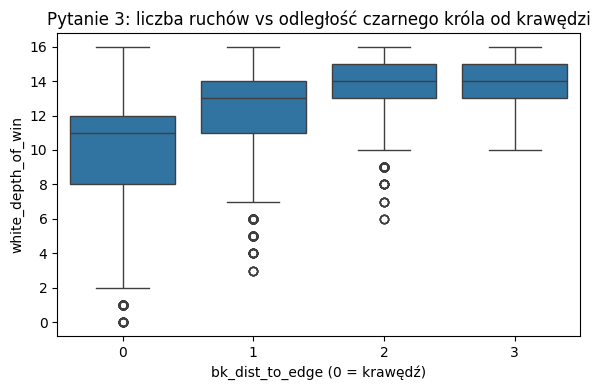

In [ ]:
df_win = df[df["white_depth_of_win"] >= 0].copy()

plt.figure(figsize=(6, 4))
sns.boxplot(
    data=df_win,
    x="black_dist_edge_2",
    y="white_depth_of_win"
)
plt.title("Pytanie 3: liczba ruchów vs odległość czarnego króla od krawędzi")
plt.xlabel("bk_dist_to_edge (0 = krawędź)")
plt.ylabel("white_depth_of_win")
plt.tight_layout()
plt.show()

Po zanalizowaniu wykresu dochodzimy do wniosku, że odległość czarnego króla od krawędzi jak najbardziej może pomóc w określeniu ile ruchów do zakończenia partii będzie potrzebne. Jeśli król znajduje się bliżej planszy liczba ruchów jest mniejsza. Dla pozycji bliższych środka ilość ta rośnie. 

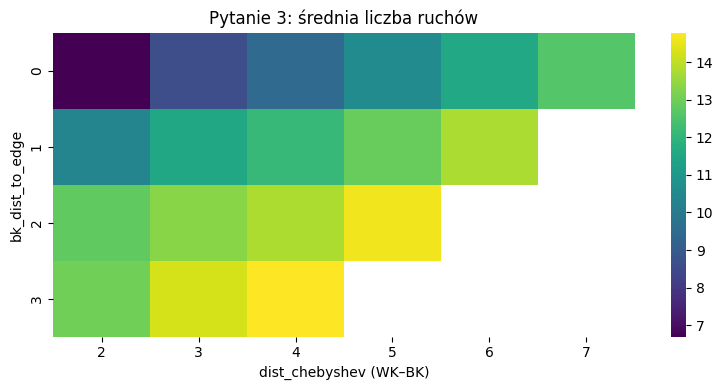

In [29]:
pivot = (
    df_win
    .pivot_table(
        values="white_depth_of_win",
        index="black_dist_edge_2",
        columns="dist_chebyshev",
        aggfunc="mean"
    )
)

plt.figure(figsize=(8, 4))
sns.heatmap(pivot, cmap="viridis")
plt.title("Pytanie 3: średnia liczba ruchów")
plt.xlabel("dist_chebyshev (WK–BK)")
plt.ylabel("bk_dist_to_edge")
plt.tight_layout()
plt.show()

widzimy tu spodziewany wynik: obie te informacje dobrze współgrają przy pomocy w określaniu ilości ruchów potrzebnych do zakończenia partii

przy mniejszej odległosci od krawędzi i mniejszej odległości króli ilość jest minimalna

przy zwiększeniu dowolnej z nich ilość potrzebnych ruchów rosnie. 
